In [3]:
!wget https://bitbucket.org/ishaanjav/code-and-deploy-custom-tensorflow-lite-model/raw/a4febbfee178324b2083e322cdead7465d6fdf95/fruits.zip

--2024-09-23 03:31:22--  https://bitbucket.org/ishaanjav/code-and-deploy-custom-tensorflow-lite-model/raw/a4febbfee178324b2083e322cdead7465d6fdf95/fruits.zip
Resolving bitbucket.org (bitbucket.org)... 13.200.41.135, 13.200.41.136, 13.200.41.134, ...
Connecting to bitbucket.org (bitbucket.org)|13.200.41.135|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105946856 (101M) [application/zip]
Saving to: ‘fruits.zip.3’

fruits.zip.3        100%[===================>] 101.04M  17.1MB/s    in 6.8s    

2024-09-23 03:31:31 (14.9 MB/s) - ‘fruits.zip.3’ saved [105946856/105946856]



In [5]:
!unzip fruits.zip

Archive:  fruits.zip
replace __MACOSX/._fruits? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._fruits       
replace fruits/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace fruits/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: fruits/.DS_Store        
  inflating: __MACOSX/fruits/._.DS_Store  
  inflating: fruits/test/.DS_Store   
  inflating: __MACOSX/fruits/test/._.DS_Store  
  inflating: fruits/train/.DS_Store  
  inflating: __MACOSX/fruits/train/._.DS_Store  
  inflating: fruits/validation/.DS_Store  
  inflating: __MACOSX/fruits/validation/._.DS_Store  
  inflating: fruits/test/apple/Screen Shot 2018-06-08 at 5.27.19 PM.png  
  inflating: __MACOSX/fruits/test/apple/._Screen Shot 2018-06-08 at 5.27.19 PM.png  
  inflating: fruits/test/apple/Screen Shot 2018-06-08 at 5.26.13 PM.png  
  inflating: __MACOSX/fruits/test/apple/._Screen Shot 2018-06-08 at 5.26.13 PM.png  
  inflating: fruits/test/apple/Screen Shot 2

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 32, 32
batch_size = 20

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2,  # Added zoom augmentation
    shear_range=0.2,  # Added shear augmentation
    brightness_range=[0.8, 1.2]  # Added brightness augmentation
)

train_ds = datagen.flow_from_directory(
    "fruits/train",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse'
)

val_datagen = ImageDataGenerator()  # No augmentation for validation
val_ds = val_datagen.flow_from_directory(
    "fruits/validation",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse'
)

test_datagen = ImageDataGenerator()  # No augmentation for test
test_ds = test_datagen.flow_from_directory(
    "fruits/test",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse'
)


Found 460 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
Found 130 images belonging to 3 classes.


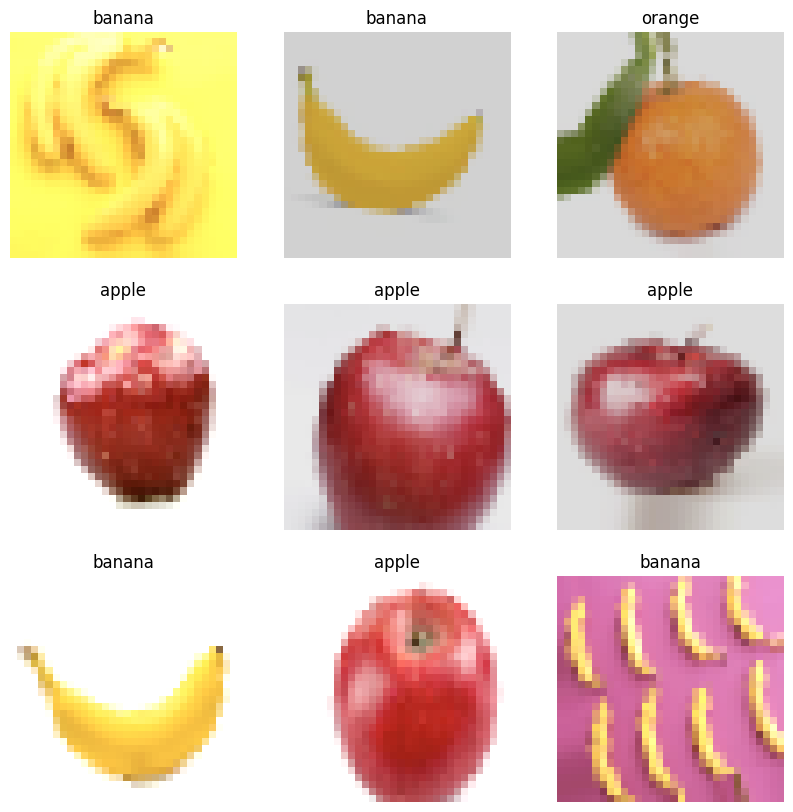

In [17]:

class_names = ["apple", "banana", "orange"]
plt.figure(figsize=(10,10))
images, labels = next(train_ds)
for i in range(9):
   ax = plt.subplot(3, 3, i + 1)
   plt.imshow(images[i].astype("uint8"))
   plt.title(class_names[int(labels[i])])
   plt.axis("off")

In [18]:
class CapsuleLayer(tf.keras.layers.Layer):
    def __init__(self, num_capsules, dim_capsule, routings=3):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        self.W = self.add_weight(shape=[input_shape[-1], self.num_capsules * self.dim_capsule],
                                 initializer='glorot_uniform', trainable=True)

    def call(self, inputs):
        inputs_hat = tf.einsum('...i,ij->...j', inputs, self.W)
        inputs_hat = tf.reshape(inputs_hat, [-1, inputs.shape[1], self.num_capsules, self.dim_capsule])
        inputs_hat = tf.transpose(inputs_hat, [0, 2, 1, 3])

        b = tf.zeros(shape=[tf.shape(inputs_hat)[0], self.num_capsules, inputs.shape[1]])

        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=1)
            s = tf.reduce_sum(c[..., tf.newaxis] * inputs_hat, axis=2)
            outputs = self.squash(s)
            if i < self.routings - 1:
                b += tf.einsum('bij,bikj->bik', outputs, inputs_hat)

        return outputs

    def squash(self, s):
        norm = tf.norm(s, axis=-1, keepdims=True)
        return (s / norm) * (norm ** 2) / (1 + norm ** 2)

# Define CapsNet Model
def create_capsnet(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(1./255)(inputs)
    x = tf.keras.layers.Conv2D(256, (5, 5), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(128, (5, 5), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Dropout(0.5)(x)  # Added dropout

    x = tf.keras.layers.Reshape((-1, 64))(x)  # Flatten while keeping the channel dimension

    capsules = CapsuleLayer(num_capsules=num_classes * 2, dim_capsule=32, routings=5)(x)  # Increased complexity
    output = tf.keras.layers.Lambda(lambda x: tf.norm(x, axis=-1))(capsules)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model


In [19]:
model = create_capsnet(input_shape=(32, 32, 3), num_classes=3)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Reduced learning rate
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,  # Increased epochs for better training
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]  # Early stopping to prevent overfitting
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3955 - loss: 1.5115 - val_accuracy: 0.6515 - val_loss: 1.1748
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6287 - loss: 1.1343 - val_accuracy: 0.7879 - val_loss: 0.9862
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8118 - loss: 0.9667 - val_accuracy: 0.8636 - val_loss: 0.8122
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8755 - loss: 0.8528 - val_accuracy: 0.8485 - val_loss: 0.7571
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8995 - loss: 0.7487 - val_accuracy: 0.9091 - val_loss: 0.6534
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9431 - loss: 0.6355 - val_accuracy: 0.9545 - val_loss: 0.5157
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 982ms/step - accuracy: 0.9377 - loss: 0.5539 - val_accuracy: 0.9091 - val_loss: 0.4995
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9488 - loss: 0.4542 - val_accuracy: 0.9394 - val_lo

In [22]:
model.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 291ms/step - accuracy: 0.9727 - loss: 0.1515


[0.21714213490486145, 0.9538461565971375]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


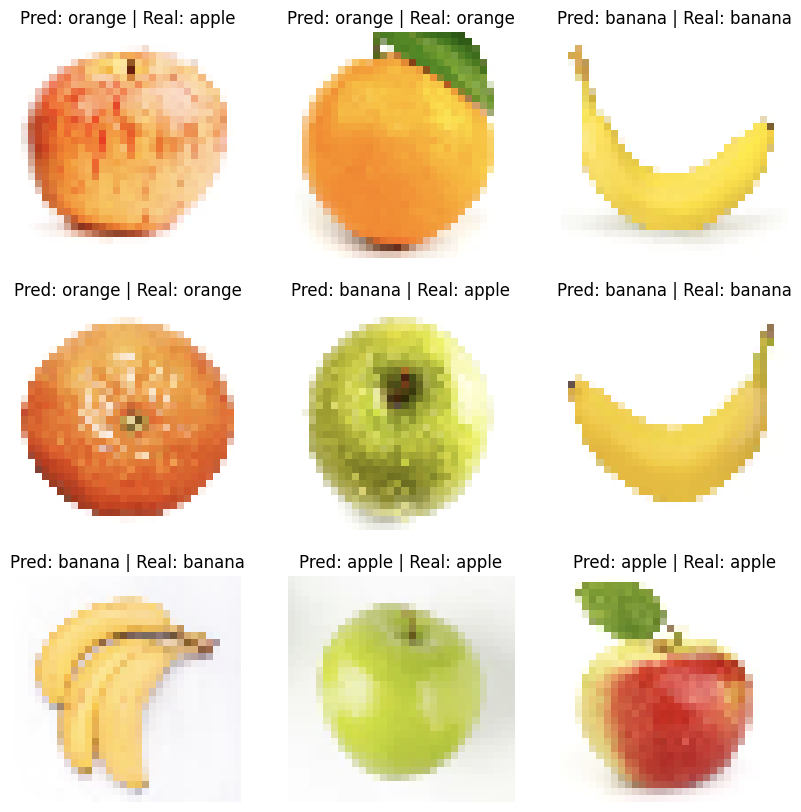

In [23]:
import numpy as np  # Import numpy

plt.figure(figsize=(10,10))

# Get a batch of images and labels from the test dataset
images, labels = next(test_ds)  # Use next() to get a batch from the DirectoryIterator

# Get the model's predictions
classifications = model.predict(images)

# Display the first 9 images along with their predictions and true labels
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    index = np.argmax(classifications[i])
    plt.title("Pred: " + class_names[index] + " | Real: " + class_names[int(labels[i])])
    plt.axis("off")

plt.show()